In [1]:
import pandas as pd
from itertools import combinations
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.api import VAR
# from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from datetime import timedelta

In [55]:
df = pd.read_csv("../data/csv/Gold_Data.csv",index_col="Business_Week")
# print(len(df.columns),len(df.index))

In [56]:
df = df.drop(df.columns[0],axis=1)
df = df.drop(df.columns[9],axis=1)
df = df.dropna(axis=1)
df = df.dropna()
# print(len(df.columns),len(df.index))

In [57]:
# df.iloc[25:30]

In [58]:
# Freq is very important, specifies when and how often data is taken.
# VAR will not work without.
df["Date"] = pd.to_datetime(df["Date"],infer_datetime_format=True)
df = df.reset_index(drop=True)
for i in range(len(df["Date"])):
    if df["Date"][i].weekday() != 1:
#         print(df["Date"][i])
        try:
            df.at[i,"Date"] = df["Date"][i-1]+timedelta(days=7)
#             print(df["Date"][i])
#             print(df["Date"][i].weekday())
        except:
            df.at[i,"Date"] = df["Date"][i+1]-timedelta(days=7)
# print(df.iloc[29,:])
df.set_index("Date",inplace=True)
df = df.asfreq("W-TUE")

In [59]:
df = df.dropna()
# len(df.index)

In [60]:
len(list(df.columns))

17

In [61]:
check_columns = list(df.columns)
check_columns.remove("Gold_Settle")

In [62]:
test_columns = [list(combination) for combination in combinations(check_columns,12)]
test_results = [coint_johansen(df[combination],-1,1) for combination in test_columns]

In [63]:
# len(test_results[12].evec)

In [64]:
# test_results[12].lr1

In [65]:
# test_results[12].cvt

In [66]:
cointegration_ranking = [sum([1 if result.lr1[i] >= result.cvt[i][2] else 0 for i in range(12)]) for result in test_results]

In [67]:
# Will break if all 12 features tested have cointegration, this is real unlikely though.
highest_coint_rank = max(cointegration_ranking)
# print(highest_coint_rank)
coint_info_index = cointegration_ranking.index(highest_coint_rank)
coint_vectors = [test_columns[coint_info_index].copy(),list(test_results[coint_info_index].evec[highest_coint_rank])]
# print(len(coint_vectors[0]))
for i in range(11,highest_coint_rank,-1):
    coint_vectors[0].pop(i)
    coint_vectors[1].pop(i)

In [68]:
modulated_series = [df[coint_vectors[0][i]]*coint_vectors[1][i] for i in range(highest_coint_rank+1)]

In [69]:
stationary_series = modulated_series.pop(0)
for series in modulated_series:
    stationary_series += series

In [70]:
df["Stationary_Conglomerate"] = stationary_series

In [71]:
df.drop(coint_vectors[0],axis=1,inplace=True)

In [72]:
df.tail()

,Gold_Settle,Producer/Merchant/Processor/User Shorts,Ten_Yr_Futures_Prev. Day Open Interest,USD_Settle,USD_Prev. Day Open Interest,ZAR_Change,ZAR_Settle,Stationary_Conglomerate
Date,,,,,,,,
2019-06-25,1392.580,190731.0,3829693.6,95.9146,46420.0,-0.19175,14.48855,-1.316646
2019-07-02,1406.920,205037.0,3782872.2,95.9638,43682.4,-0.28325,14.27985,-1.082013
2019-07-09,1405.375,207701.0,3749954.5,96.7262,41304.8,0.05575,14.24630,-2.446835
2019-07-16,1411.220,211517.0,3759147.8,96.6758,42843.8,-0.21575,14.05680,-0.513137
2019-07-23,1425.340,217199.0,3796138.0,96.8954,41641.0,-0.05900,13.99895,2.832372


In [73]:
scaler = MinMaxScaler()

In [74]:
normalized_df = scaler.fit_transform(df)
normalized_df = pd.DataFrame(normalized_df,index=df.index,columns=df.columns)
normalized_df.tail()

,Gold_Settle,Producer/Merchant/Processor/User Shorts,Ten_Yr_Futures_Prev. Day Open Interest,USD_Settle,USD_Prev. Day Open Interest,ZAR_Change,ZAR_Settle,Stationary_Conglomerate
Date,,,,,,,,
2019-06-25,0.642375,0.413292,0.833242,0.772377,0.257492,0.346381,0.770509,0.611633
2019-07-02,0.653581,0.461023,0.819600,0.773950,0.236145,0.307765,0.750169,0.615486
2019-07-09,0.652374,0.469911,0.810009,0.798327,0.217605,0.450834,0.746900,0.593073
2019-07-16,0.656941,0.482642,0.812688,0.796716,0.229606,0.336252,0.728432,0.624829
2019-07-23,0.667974,0.501600,0.823465,0.803737,0.220226,0.402406,0.722794,0.679770


In [75]:
train = normalized_df.iloc[:int(.8*(len(normalized_df.index)))]
test = normalized_df.iloc[int(.8*(len(normalized_df.index))):]

In [76]:
model = VAR(endog=train)

In [77]:
fit_model = model.fit(maxlags=15, ic='aic')

In [78]:
fit_model.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 29, Jul, 2019
Time:                     08:16:21
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                   -46.6071
Nobs:                     534.000    HQIC:                  -51.0179
Log likelihood:           9221.12    FPE:                4.30902e-24
AIC:                     -53.8533    Det(Omega_mle):     9.27843e-25
--------------------------------------------------------------------
Results for equation Gold_Settle
                                                 coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------------------------
const                                               0.038126         0.081948            0.465           0.642
L1.Gold_Settle                               

In [79]:
fit_model.plot()

<Figure size 1000x1000 with 8 Axes>

In [80]:
predictions = fit_model.forecast(fit_model.y,steps=len(test.index))
predictions = pd.DataFrame(predictions,index=test.index,columns=test.columns)

In [81]:
for column in predictions.columns:
    print(f"RMSE for {column} is : {sqrt(mean_squared_error(test[column],predictions[column]))}")

RMSE for Gold_Settle is : 0.13501887430078718
RMSE for Producer/Merchant/Processor/User Shorts is : 0.17354785557770944
RMSE for Ten_Yr_Futures_Prev. Day Open Interest is : 0.1713392608810518
RMSE for USD_Settle is : 0.15034860152763366
RMSE for USD_Prev. Day Open Interest is : 0.20229890088603583
RMSE for ZAR_Change is : 0.12717375476764806
RMSE for ZAR_Settle is : 0.10586977746702518
RMSE for Stationary_Conglomerate is : 0.11781789629175565


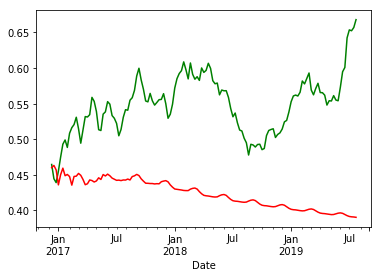

In [83]:
ax1 = test["Gold_Settle"].plot(color="green")
ax2 = predictions["Gold_Settle"].plot(color="red")

In [ ]:
final_test_stationarity = coint_johansen(df,-1,1)

In [ ]:
sum([1 if final_test_stationarity.lr1[i] >= final_test_stationarity.cvt[i][2] else 0 for i in range(len(df.columns))])

In [ ]:
final_test_stationarity.lr1

In [ ]:
final_test_stationarity.cvt

In [ ]:
final_test_stationarity.eig

In [ ]:
# Need to automate process of conglomerating things for stationarity. Maybe